# Projet : Détection d'Anomalies dans les Signaux ECG
## Approche Semi-Supervisée avec Autoencodeur Simple

**Mission :** Concevoir un algorithme capable de détecter des anomalies (classes R et V) en utilisant une approche semi-supervisée, en entraînant un modèle uniquement sur les signaux normaux (classe N)[^1].

## 1. Initialisation : Imports et Configuration

In [59]:
import warnings
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_auc_score, f1_score, precision_recall_curve, auc
)
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")

TensorFlow: 2.20.0
NumPy: 2.3.4


## 2. Chargement et Visualisation des Données

Nous chargeons le fichier `ecg_dataset.mat`[^2]. Les données sont très déséquilibrées : 97.8% des signaux sont normaux (Classe N)[^3], ce qui justifie notre approche de détection d'anomalies.

Données chargées : 5405 signaux × 146 points

Distribution :
  Classe 0 : 5288 ( 97.8%)
  Classe 1 :  111 (  2.1%)
  Classe 2 :    6 (  0.1%)


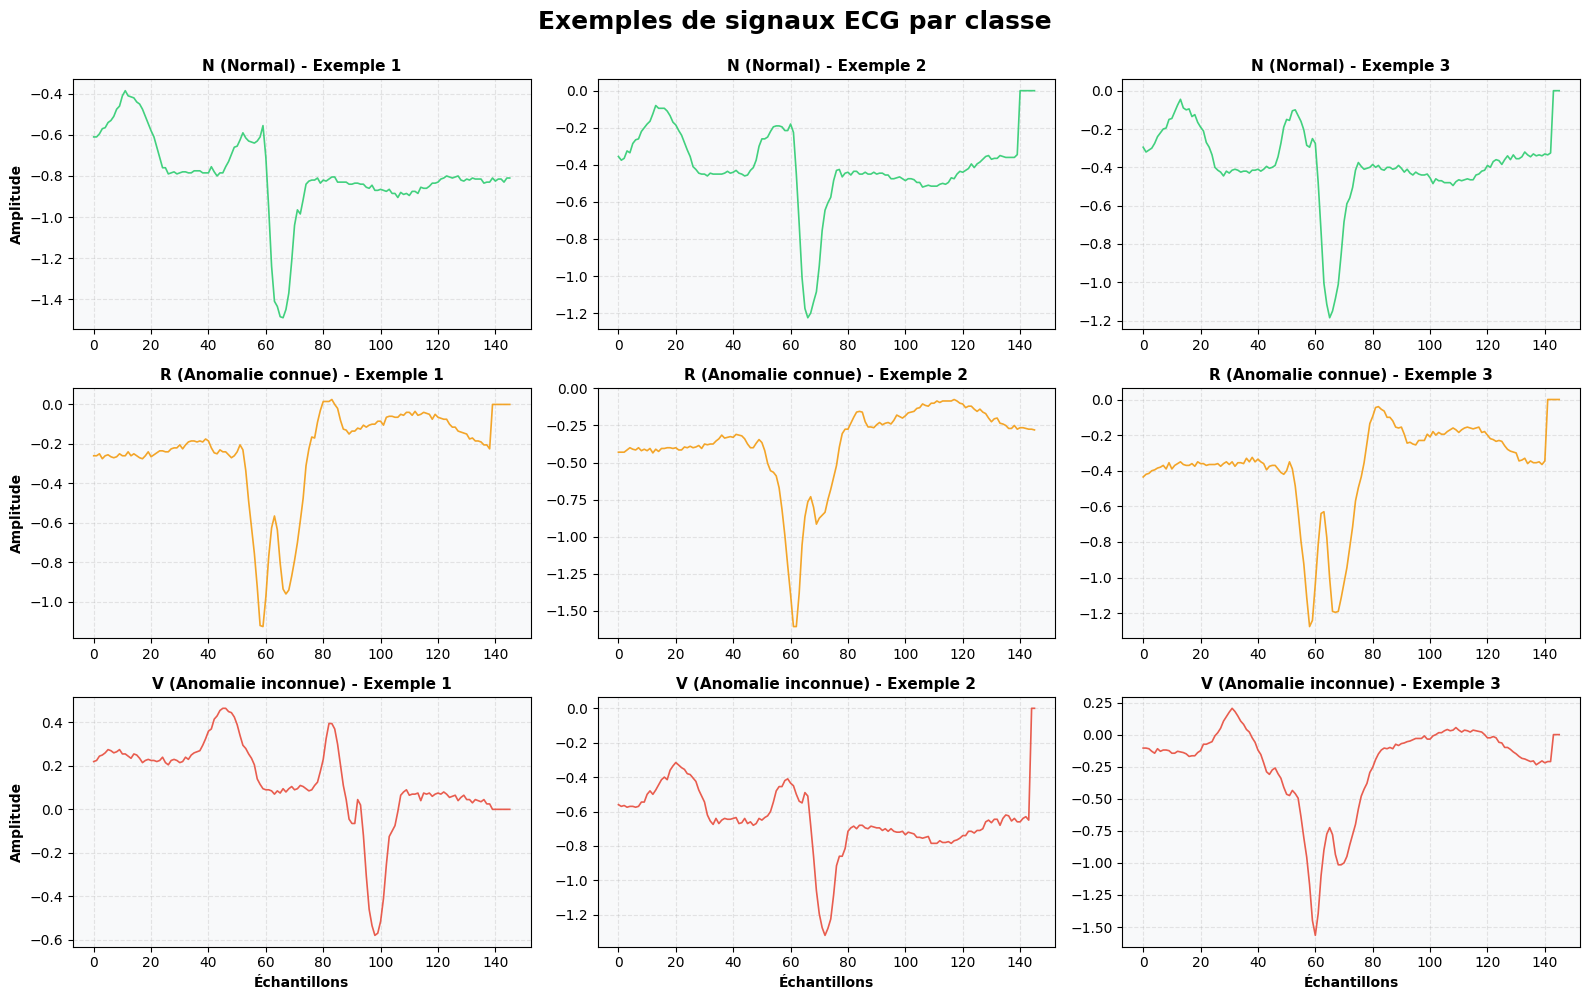

In [73]:
data = loadmat('ecg_dataset.mat')
X = data['X']
y = data['y'].flatten()

print(f"Données chargées : {X.shape[0]} signaux × {X.shape[1]} points")

# Distribution
print(f"\nDistribution :")
labels_desc = {
    0: "N (Battements normaux)",
    1: "R (Anomalies connues - extrasystoles)",
    2: "V (Anomalies inconnues - fibrillation ventriculaire)"
}
for c in [0, 1, 2]:
    count = np.sum(y == c)
    print(f"  Classe {c} : {count:4d} ({count/len(y)*100:5.1f}%)")

# Visualisation
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
fig.suptitle('Exemples de signaux ECG par classe', fontsize=18, fontweight='bold', y=0.995)
labels = {0: "N (Normal)", 1: "R (Anomalie connue)", 2: "V (Anomalie inconnue)"}
colors = {0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'}

for i, classe in enumerate([0, 1, 2]):
    indices = np.where(y == classe)[0]
    for j in range(3):
        if j < len(indices):
            idx = indices[j]
            axes[i, j].plot(X[idx], linewidth=1.2, color=colors[classe], alpha=0.9)
            axes[i, j].set_title(f"{labels[classe]} - Exemple {j + 1}", fontsize=11, fontweight='bold')
            axes[i, j].grid(True, alpha=0.3, linestyle='--')
            axes[i, j].set_facecolor('#f8f9fa')
        if j == 0:
            axes[i, j].set_ylabel('Amplitude', fontsize=10, fontweight='bold')
        if i == 2:
            axes[i, j].set_xlabel('Échantillons', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Prétraitement et Stratégie

### Stratégie Semi-Supervisée
Le problème principal est la détection de la classe V, qui est rare et inconnue. Un classificateur supervisé standard ne pourrait pas généraliser à ces anomalies inconnues. 

Nous adoptons donc une approche semi-supervisée : 
1.  **Entraînement :** Le modèle n'apprendra qu'à reconstruire les signaux normaux (Classe N).
2.  **Détection :** Nous partons du principe que le modèle échouera à reconstruire les signaux anormaux (R et V), produisant une erreur de reconstruction (MSE) élevée. Cette erreur devient notre score d'anomalie.

### Prétraitement (StandardScaler)
Nous normalisons les signaux (mise à l'échelle Z-score). Pour éviter toute **fuite de données** (data leakage), le `StandardScaler` est entraîné (`fit`) **uniquement** sur les données normales. Ce même scaler sera ensuite utilisé pour transformer toutes les données (normales et anormales) lors de la phase de détection.

In [61]:
# 1. Séparer les données pour l'entraînement du scaler
X_good = X[y == 0]
print(f"Signaux normaux extraits pour l'entraînement : {X_good.shape[0]}")

# 2. Entraîner le scaler UNIQUEMENT sur les données normales
scaler = StandardScaler()
scaler.fit(X_good)

# 3. Appliquer aux données normales
X_good_normalized = scaler.transform(X_good)
print(f"Normalisation appliquée. Moyenne (vérif): {np.mean(X_good_normalized):.2f}, Std (vérif): {np.std(X_good_normalized):.2f}")

# 4. Diviser les données normales en ensembles d'entraînement et de validation
X_train, X_val = train_test_split(X_good_normalized, test_size=0.2, random_state=42)

# 5. Reshape pour Conv1D (samples, timesteps, features)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}")

Signaux normaux extraits pour l'entraînement : 5288
Normalisation appliquée. Moyenne (vérif): 0.00, Std (vérif): 1.00
Train: 4230, Val: 1058


## 4. Définition et Justification du Modèle [^4]

Nous utilisons un **Autoencodeur Convolutionnel (AE-CNN)**. 

* **Convolutionnel (Conv1D) :** Idéal pour les séquences (comme l'ECG), car il capture les motifs locaux (ondes P, QRS, T) indépendamment de leur position exacte.
* **Autoencodeur :** L'architecture encodeur-décodeur force le modèle à apprendre une représentation compressée (le *bottleneck*).
* **Bottleneck (8 filtres) :** Nous utilisons un goulot d'étranglement de 8 filtres. C'est un choix crucial : il est assez grand pour capturer la structure des signaux normaux, mais trop petit pour mémoriser les détails spécifiques des signaux anormaux, ce qui est la clé de la détection.

In [62]:
def create_autoencoder(input_shape=(146, 1)):
    """Autoencodeur simple et efficace"""
    inputs = layers.Input(shape=input_shape, name='input_layer')
    
    # Encodeur
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(8, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.MaxPooling1D(2, padding='same')(x) # Bottleneck: (None, 19, 8)
    
    # Décodeur
    x = layers.Conv1D(8, 7, activation='relu', padding='same')(encoded)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(32, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(64, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling1D(2)(x)
    
    x = layers.Conv1D(1, 7, activation='linear', padding='same')(x)
    decoded = layers.Cropping1D((3, 3))(x) # 152 -> 146
    
    return Model(inputs, decoded, name='ECG_Autoencoder')

autoencoder = create_autoencoder(X_train.shape[1:])

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse', # Mean Squared Error: parfait pour une tâche de reconstruction
    metrics=['mae']
)

autoencoder.summary()

Model: "ECG_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 146, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 146, 64)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 146, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_21 (MaxPooling1D) │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 73, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (None, 73, 32)         │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 73, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_22 (MaxPooling1D) │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 37, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 37, 8)          │         1,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 37, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_23 (MaxPooling1D) │ (None, 19, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (None, 19, 8)          │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 19, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_15 (UpSampling1D) │ (None, 38, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 38, 32)         │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 38, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_16 (UpSampling1D) │ (None, 76, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 76, 64)         │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 76, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_17 (UpSampling1D) │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 152, 1)         │           44

 Total params: 34,641 (135.32 KB)

 Trainable params: 34,225 (133.69 KB)

 Non-trainable params: 416 (1.62 KB)

## 5. Entraînement

Nous entraînons le modèle en lui demandant de se reconstruire lui-même (`X_train` -> `X_train`). Nous utilisons `EarlyStopping` pour arrêter l'entraînement lorsque la perte de validation (`val_loss`) cesse de s'améliorer, évitant ainsi le surapprentissage.

In [63]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    verbose=1
)

print(f"\nEntraînement terminé")

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.6108 - mae: 0.4816 - val_loss: 0.6434 - val_mae: 0.4842 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2689 - mae: 0.3103 - val_loss: 0.5789 - val_mae: 0.4582 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.2263 - mae: 0.2816 - val_loss: 0.4898 - val_mae: 0.4342 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1918 - mae: 0.2626 - val_loss: 0.4475 - val_mae: 0.4100 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1729 - mae: 0.2542 - val_loss: 0.3432 - val_mae: 0.3445 - learning_rate: 0.0010
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1569 - mae: 0.2433 - val_loss: 0.2727 - val_mae: 0.3419 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1441 - mae: 0.2410 - val_loss: 0.2713 - val_mae: 0.3676 - learning_rate: 0.0010
Epoch 

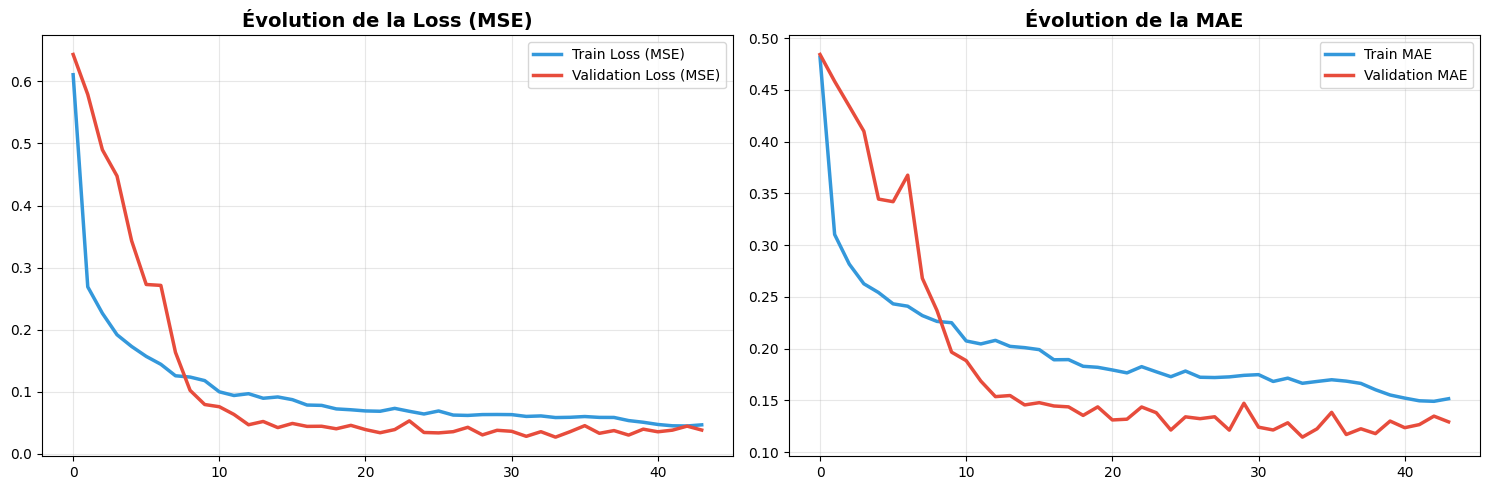

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(history.history['loss'], label='Train Loss (MSE)', linewidth=2.5, color='#3498db')
axes[0].plot(history.history['val_loss'], label='Validation Loss (MSE)', linewidth=2.5, color='#e74c3c')
axes[0].set_title('Évolution de la Loss (MSE)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2.5, color='#3498db')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2.5, color='#e74c3c')
axes[1].set_title('Évolution de la MAE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Évaluation et Détermination du Seuil [^9]

L'entraînement est terminé. Nous allons maintenant :
1.  Normaliser **l'intégralité** du jeu de données `X` (en utilisant le `scaler` entraîné sur les données normales).
2.  Utiliser le modèle pour **reconstruire** tous les signaux.
3.  Calculer l'erreur (MSE) pour chaque signal.
4.  Comparer les distributions d'erreurs entre les classes normales et anormales.

In [65]:
print(f"\nCalcul des erreurs de reconstruction...")
# 1. Normaliser toutes les données (avec le scaler d'entraînement)
X_norm = scaler.transform(X)
X_input = X_norm[..., np.newaxis]

# 2. Prédire / Reconstruire
reconstructions = autoencoder.predict(X_input, verbose=0).squeeze()

# 3. Calculer l'erreur MSE
mse = np.mean(np.square(X_norm - reconstructions), axis=1)

print(f"MSE calculées")
print(f"  Normal    : {np.mean(mse[y == 0]):.6f}")
print(f"  Anomalie  : {np.mean(mse[y != 0]):.6f}")
print(f"  Ratio     : {np.mean(mse[y != 0]) / np.mean(mse[y == 0]):.2f}×")

# 4. Trouver le meilleur seuil
y_true = (y != 0).astype(int)
precision, recall, thresholds = precision_recall_curve(y_true, mse)
f1s = (2 * precision * recall) / (precision + recall + 1e-9)
valid_thresholds = thresholds[:len(f1s)]
best_f1_idx = np.argmax(f1s)
best_threshold = valid_thresholds[best_f1_idx]

print(f"\nSeuil de détection (optimisé F1) : {best_threshold:.6f}")


Calcul des erreurs de reconstruction...
MSE calculées
  Normal    : 0.028101
  Anomalie  : 0.238896
  Ratio     : 8.50×

Seuil de détection (optimisé F1) : 0.138548


## 7. Analyse des Performances [^10]

Nous évaluons le modèle en utilisant le seuil F1-optimal. Nous regardons la **matrice de confusion** pour les Faux Positifs/Négatifs, et le **rapport de classification**.

Nous utilisons l'**AUC-PR** (Area Under Precision-Recall Curve) comme métrique principale, car elle est beaucoup plus fiable que l'AUC-ROC sur des données déséquilibrées[^10].

In [66]:
# Utiliser le seuil F1 pour les prédictions finales
y_pred = (mse > best_threshold).astype(int)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
print("\nMatrice de confusion (Seuil F1) :")
print("                   Prédit Normal   Prédit Anomalie")
print(f"Vrai Normal         {cm[0, 0]:6d}         {cm[0, 1]:6d}")
print(f"Vrai Anomalie       {cm[1, 0]:6d}         {cm[1, 1]:6d}")

# Rapport de classification
print("\nRapport de classification (Seuil F1) :")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalie'], digits=3))

# Métriques AUC
auc_pr = auc(recall, precision)
auc_roc = roc_auc_score(y_true, mse)
f1 = f1_score(y_true, y_pred)

print(f"AUC-ROC Score : {auc_roc:.3f} (Pour information)")
print(f"AUC-PR Score  : {auc_pr:.3f} (Métrique recommandée)")
print(f"F1-Score      : {f1:.3f}")

print("\nTaux de détection (par classe) :")

# Classe N (Faux Positifs)
fp_n = cm[0, 1]
total_n = np.sum(y == 0)
print(f"  Classe N : {fp_n}/{total_n} faux positifs ({fp_n/total_n*100:.1f}%)")

# Classe R (Détectés)
y_true_r = (y == 1)
y_pred_r = (y_pred == 1)
detected_r = np.sum(y_true_r & y_pred_r)
total_r = np.sum(y_true_r)
print(f"  Classe R : {detected_r}/{total_r} détectés ({detected_r/total_r*100:.1f}%)")

# Classe V (Détectés)
y_true_v = (y == 2)
y_pred_v = (y_pred == 1)
detected_v = np.sum(y_true_v & y_pred_v)
total_v = np.sum(y_true_v)
print(f"  Classe V : {detected_v}/{total_v} détectés ({detected_v/total_v*100:.1f}%)")


Matrice de confusion (Seuil F1) :
                   Prédit Normal   Prédit Anomalie
Vrai Normal           5187            101
Vrai Anomalie            9            108

Rapport de classification (Seuil F1) :
              precision    recall  f1-score   support

      Normal      0.998     0.981     0.990      5288
    Anomalie      0.517     0.923     0.663       117

    accuracy                          0.980      5405
   macro avg      0.758     0.952     0.826      5405
weighted avg      0.988     0.980     0.982      5405

AUC-ROC Score : 0.990 (Pour information)
AUC-PR Score  : 0.489 (Métrique recommandée)
F1-Score      : 0.663

Taux de détection (par classe) :
  Classe N : 101/5288 faux positifs (1.9%)
  Classe R : 102/111 détectés (91.9%)
  Classe V : 6/6 détectés (100.0%)


## 8. Visualisation des Distributions d'Erreurs

Ces graphiques confirment que le modèle fonctionne : l'erreur (MSE) des signaux normaux (verts) est très faible et concentrée à gauche, tandis que les erreurs des anomalies (orange et rouge) sont significativement plus élevées. Notre seuil (ligne violette) sépare bien les deux groupes.

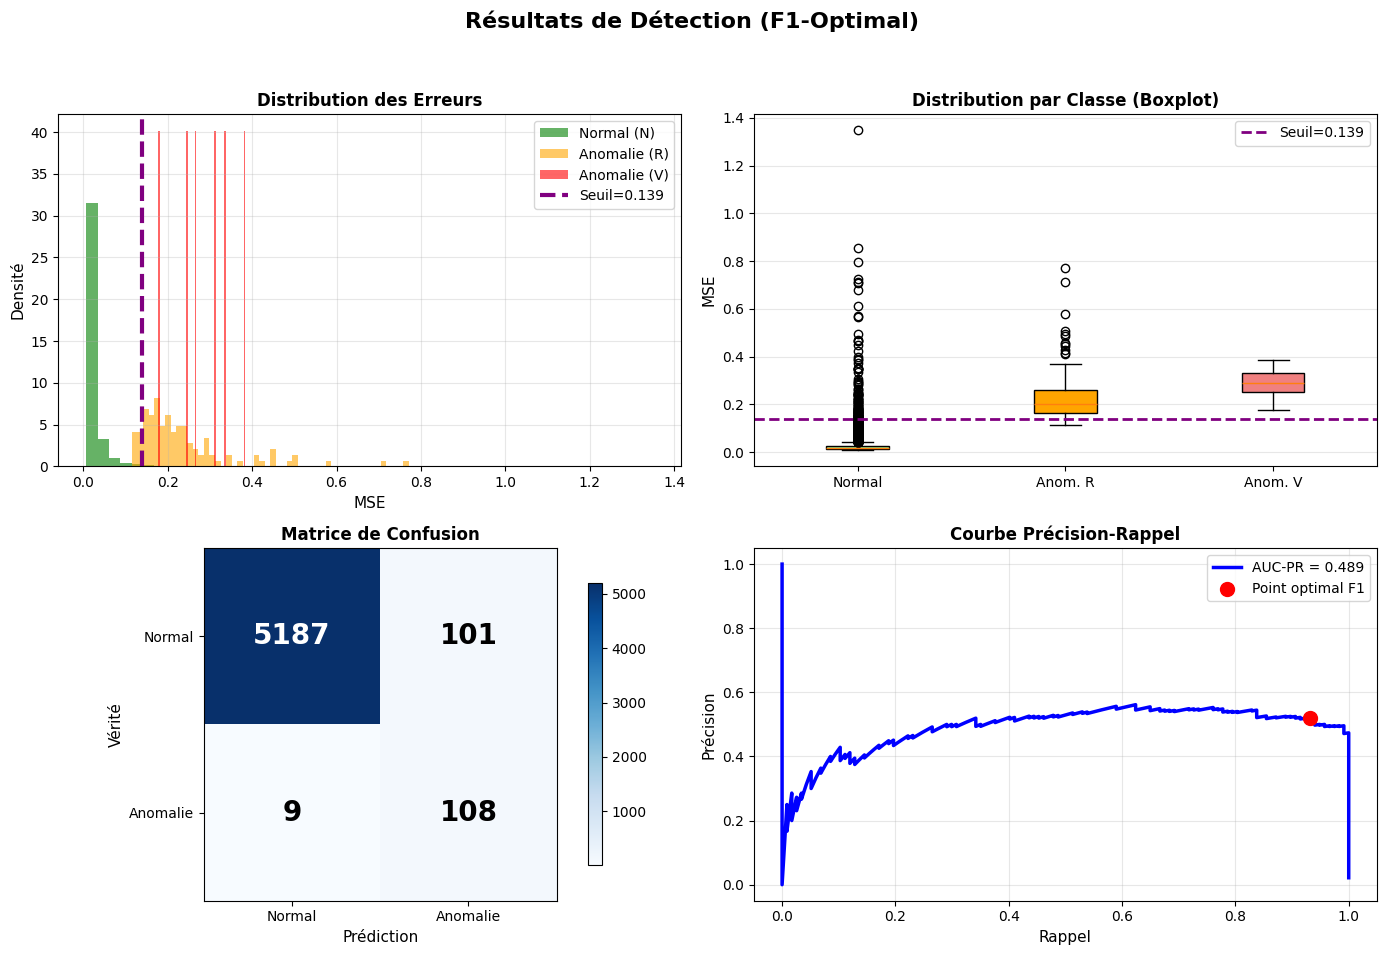

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Résultats de Détection (F1-Optimal)', fontsize=16, fontweight='bold')

# Plot 1: Distribution
ax = axes[0, 0]
ax.hist(mse[y == 0], bins=50, alpha=0.6, label='Normal (N)', color='green', density=True)
ax.hist(mse[y == 1], bins=50, alpha=0.6, label='Anomalie (R)', color='orange', density=True)
ax.hist(mse[y == 2], bins=50, alpha=0.6, label='Anomalie (V)', color='red', density=True)
ax.axvline(best_threshold, color='purple', linestyle='--', linewidth=3, label=f'Seuil={best_threshold:.3f}')
ax.set_xlabel('MSE', fontsize=11)
ax.set_ylabel('Densité', fontsize=11)
ax.set_title('Distribution des Erreurs', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Boxplots
ax = axes[0, 1]
data_to_plot = [mse[y == 0], mse[y == 1], mse[y == 2]]
bp = ax.boxplot(data_to_plot, labels=['Normal', 'Anom. R', 'Anom. V'], patch_artist=True)
colors = ['lightgreen', 'orange', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.axhline(best_threshold, color='purple', linestyle='--', linewidth=2, label=f'Seuil={best_threshold:.3f}')
ax.set_ylabel('MSE', fontsize=11)
ax.set_title('Distribution par Classe (Boxplot)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Matrice de confusion
ax = axes[1, 0]
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.set_title('Matrice de Confusion', fontsize=12, fontweight='bold')
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center",
                       color="white" if cm[i, j] > cm.max() / 2 else "black",
                       fontsize=20, fontweight='bold')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Normal', 'Anomalie'])
ax.set_yticklabels(['Normal', 'Anomalie'])
ax.set_ylabel('Vérité', fontsize=11)
ax.set_xlabel('Prédiction', fontsize=11)
plt.colorbar(im, ax=ax, shrink=0.8)

# Plot 4: Courbe Precision-Recall
ax = axes[1, 1]
ax.plot(recall, precision, linewidth=2.5, color='blue', label=f'AUC-PR = {auc_pr:.3f}')
ax.scatter(recall[best_f1_idx], precision[best_f1_idx], 
           color='red', s=100, zorder=5, label='Point optimal F1')
ax.set_xlabel('Rappel', fontsize=11)
ax.set_ylabel('Précision', fontsize=11)
ax.set_title('Courbe Précision-Rappel', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 9. Analyse des Erreurs (Faux Négatifs) 

Nous examinons les cas où le modèle a échoué. Un "Faux Négatif" est une anomalie que le modèle a classée comme "Normale" (parce que son erreur de reconstruction était *inférieure* au seuil). C'est le cas le plus dangereux.

Nous allons tracer :
1.  **Vrai Positif (Normal) :** Un signal normal, bien reconstruit (Erreur faible).
2.  **Vrai Positif (Anomalie) :** Un signal anormal, mal reconstruit (Erreur élevée).
3.  **Faux Négatif (Erreur) :** Un signal anormal que le modèle a *réussi* à reconstruire (Erreur faible).

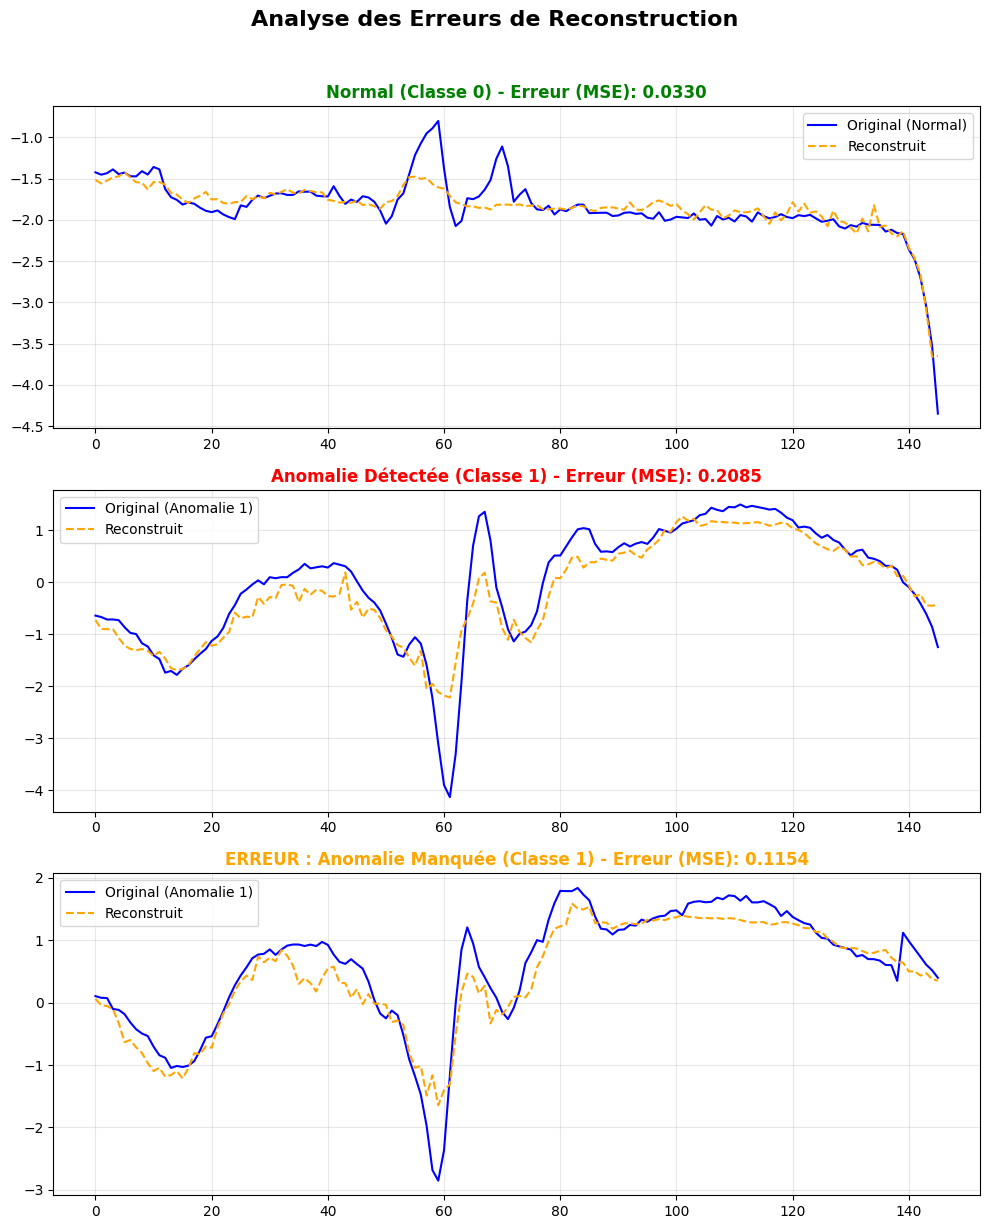

In [68]:
# 1. Trouver les index des cas d'intérêt
y_true = (y != 0).astype(int)
y_pred = (mse > best_threshold).astype(int)

# Vrai Positif (Normal bien classé)
idx_tn = np.where((y_true == 0) & (y_pred == 0))[0][0]

# Vrai Positif (Anomalie bien classée)
idx_tp = np.where((y_true == 1) & (y_pred == 1))[0][0]

# Faux Négatif (Anomalie manquée)
idx_fn = np.where((y_true == 1) & (y_pred == 0))[0]
idx_fn_example = idx_fn[0] if len(idx_fn) > 0 else idx_tp # Prend un TP si aucun FN n'est trouvé
label_fn = y[idx_fn_example]

# 2. Graphiques
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Analyse des Erreurs de Reconstruction', fontsize=16, fontweight='bold', y=1.02)
time_steps = np.arange(X.shape[1])

# Vrai Négatif (Normal)
axes[0].plot(time_steps, X_norm[idx_tn], 'blue', label='Original (Normal)')
axes[0].plot(time_steps, reconstructions[idx_tn], 'orange', linestyle='--', label='Reconstruit')
axes[0].set_title(f"Normal (Classe {y[idx_tn]}) - Erreur (MSE): {mse[idx_tn]:.4f}", fontweight='bold', color='green')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Vrai Positif (Anomalie)
axes[1].plot(time_steps, X_norm[idx_tp], 'blue', label=f'Original (Anomalie {y[idx_tp]})')
axes[1].plot(time_steps, reconstructions[idx_tp], 'orange', linestyle='--', label='Reconstruit')
axes[1].set_title(f"Anomalie Détectée (Classe {y[idx_tp]}) - Erreur (MSE): {mse[idx_tp]:.4f}", fontweight='bold', color='red')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Faux Négatif (Anomalie Manquée)
axes[2].plot(time_steps, X_norm[idx_fn_example], 'blue', label=f'Original (Anomalie {label_fn})')
axes[2].plot(time_steps, reconstructions[idx_fn_example], 'orange', linestyle='--', label='Reconstruit')
axes[2].set_title(f"ERREUR : Anomalie Manquée (Classe {label_fn}) - Erreur (MSE): {mse[idx_fn_example]:.4f}", fontweight='bold', color='orange')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Conclusion et Sauvegarde

Le modèle AE-CNN, entraîné uniquement sur les données normales, démontre sa capacité à généraliser et à détecter des anomalies inconnues (V) et connues (R) en se basant sur l'erreur de reconstruction.

Il respecte la contrainte de performance (modèle léger de 34k paramètres) pour un déploiement sur Raspberry Pi[^11].

In [70]:
# Sauvegarde
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_file = f"ecg_autoencoder_{timestamp}.keras"
autoencoder.save(model_file)
print(f"\nModèle sauvegardé : {model_file}")

print(f"\n{'='*80}")
print("PROJET TERMINÉ - RÉSUMÉ")
print(f"{'='*80}")
print(f"Seuil F1-Optimal : {best_threshold:.6f}")
print(f"F1-Score (Anomalie) : {f1:.3f}")
print(f"AUC-PR (Fiable) : {auc_pr:.3f}")


Modèle sauvegardé : ecg_autoencoder_20251103_193332.keras

PROJET TERMINÉ - RÉSUMÉ
Seuil F1-Optimal : 0.138548
F1-Score (Anomalie) : 0.663
AUC-PR (Fiable) : 0.489
